# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [19]:
# import libraries
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark
#from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql.functions import isnan, when, count, col, isnull, desc, asc, udf, max, sum, mean, countDistinct, datediff
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [20]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify-App").getOrCreate()

In [21]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '44011'),
 ('spark.app.id', 'local-1555480185928'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'Sparkify-App'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'ca58fd6b047b'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [22]:
path = 'mini_sparkify_event_data.json'
data = spark.read.json(path)
print(data.count())
print(len(data.columns))
data.printSchema()

286500
18
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [23]:
#data.take(5)
data.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [24]:
#data.describe().show()
data.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [25]:
data.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [26]:
# Get count of null or Nan values
data.select([count(when(isnan(c) | isnull(c), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [27]:
# Get count of empty strings 
print(data.filter(data['userId'] == '').count())    #print(data.where(data.userId =='').count())
print(data.filter(data['sessionId'] == '').count())

columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
data.select([count(when(col(c)=='', c)).alias(c) for c in columns]).show()

8346
0
+------+----+---------+------+--------+-----+--------+------+----+----+---------+------+
|artist|auth|firstName|gender|lastName|level|location|method|page|song|userAgent|userId|
+------+----+---------+------+--------+-----+--------+------+----+----+---------+------+
|     0|   0|        0|     0|       0|    0|       0|     0|   0|   0|        0|  8346|
+------+----+---------+------+--------+-----+--------+------+----+----+---------+------+



8346 rows don't have any user information. This means these records were for un-registered users. These rows also have null values in firstName, lastName, gender, location and registration. We can safely remove these rows.

In [28]:
data = data.filter(data['userId'] != '')
print(data.count())

278154


In [29]:
data.select([count(when(isnan(c) | isnull(c), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [30]:
# data.write.save('processed_logs.csv', format='csv', header=True)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
for column in data.columns:
    print('Column: {}'.format(column.title()))
    print('Number of unique values: {}'.format(data.select(column).dropDuplicates().count()))
    print('Unique values:')
    data.select(column).dropDuplicates().sort(column).show(5)

Column: Artist
Number of unique values: 17656
Unique values:
+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
+--------------------+
only showing top 5 rows

Column: Auth
Number of unique values: 2
Unique values:
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

Column: Firstname
Number of unique values: 189
Unique values:
+---------+
|firstName|
+---------+
| Adelaida|
|   Adrian|
|  Adriana|
|   Adriel|
|  Ainsley|
+---------+
only showing top 5 rows

Column: Gender
Number of unique values: 2
Unique values:
+------+
|gender|
+------+
|     F|
|     M|
+------+

Column: Iteminsession
Number of unique values: 1311
Unique values:
+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
+-------------+
only showing top 5 rows

Column: Lastname
Number of unique va

In [32]:
# data.select("page").distinct().sort("page").show()
data.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [33]:
flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
#flag_downgrade_event = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
data = data.withColumn('Churn', flag_cancellation_event('page'))  #.withColumn("downgraded", flag_downgrade_event("page"))
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [34]:
data.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozi

In [35]:
data.select(['userId', 'auth', 'itemInSession', 'page',  'length', 'level', 'ts', 'song', 'churn']).where(data.userId == '18').show(10)

+------+---------+-------------+--------+---------+-----+-------------+--------------------+-----+
|userId|     auth|itemInSession|    page|   length|level|           ts|                song|churn|
+------+---------+-------------+--------+---------+-----+-------------+--------------------+-----+
|    18|Logged In|            0|    Home|     null| paid|1538499917000|                null|    0|
|    18|Logged In|            1|NextSong|275.12118| paid|1538499933000|A Beggar On A Bea...|    0|
|    18|Logged In|            2|NextSong|268.32934| paid|1538500208000|...slowdance On T...|    0|
|    18|Logged In|            3|NextSong|178.72934| paid|1538500476000|       St. Apollonia|    0|
|    18|Logged In|            4|NextSong|188.76036| paid|1538500654000|      Drunk Stripper|    0|
|    18|Logged In|            5|NextSong|167.91465| paid|1538500842000|In League With Satan|    0|
|    18|Logged In|            6|Settings|     null| paid|1538500856000|                null|    0|
|    18|Lo

In [36]:
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
#data = data.withColumn('phase', sum('downgraded').over(windowval))
data = data.withColumn('churnedUser', max('churn').over(Window.partitionBy('userId')))
data.select(['userId', 'auth', 'itemInSession', 'page',  'length', 'level', 'ts', 'song', 'churn', 'churnedUser']).where(data.userId == '18').show(10)

+------+---------+-------------+--------+---------+-----+-------------+--------------------+-----+-----------+
|userId|     auth|itemInSession|    page|   length|level|           ts|                song|churn|churnedUser|
+------+---------+-------------+--------+---------+-----+-------------+--------------------+-----+-----------+
|    18|Logged In|            0|    Home|     null| paid|1538499917000|                null|    0|          1|
|    18|Logged In|            1|NextSong|275.12118| paid|1538499933000|A Beggar On A Bea...|    0|          1|
|    18|Logged In|            2|NextSong|268.32934| paid|1538500208000|...slowdance On T...|    0|          1|
|    18|Logged In|            3|NextSong|178.72934| paid|1538500476000|       St. Apollonia|    0|          1|
|    18|Logged In|            4|NextSong|188.76036| paid|1538500654000|      Drunk Stripper|    0|          1|
|    18|Logged In|            5|NextSong|167.91465| paid|1538500842000|In League With Satan|    0|          1|
|

In [37]:
next_song_events = data.filter(data.page == 'NextSong')
next_song_events.count()

228108

In [38]:
# total_songs_played = next_song_events.groupby(next_song_events.churnedUser).count()
songs_played = next_song_events.groupby(next_song_events.churnedUser)\
                        .agg(countDistinct('userId'), count('page'))\
                        .withColumn('Avg Songs Per User', col('count(page)')/col('count(DISTINCT userId)'))

songs_played.show()

+-----------+----------------------+-----------+------------------+
|churnedUser|count(DISTINCT userId)|count(page)|Avg Songs Per User|
+-----------+----------------------+-----------+------------------+
|          1|                    52|      36394| 699.8846153846154|
|          0|                   173|     191714|1108.1734104046243|
+-----------+----------------------+-----------+------------------+



In [39]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
convert = 1000*60*60*24

temp = data.select(['userId', 'ts', 'registration'])
registration_timestamp = temp.groupby('userId').min("registration")
min_timestmp = temp.select(['userId', 'ts']).groupby('userId').min('ts')
max_timestmp = temp.select(['userId', 'ts']).groupby('userId').max('ts')

joined = registration_timestamp.join(min_timestmp, on='userId').join(max_timestmp, on='userId')
joined = joined.withColumn('Registration Date', get_date('min(registration)')).withColumn('Max Date', get_date('max(ts)')) \
               .withColumn('Min Date', get_date('min(ts)')) \
               .withColumn('Days',  datediff(col('Max Date'), col('Registration Date'))) \
               .withColumn("Days_2", (col("max(ts)")-col("min(registration)")) / convert)

joined.show()

+------+-----------------+-------------+-------------+-----------------+----------+----------+----+------------------+
|userId|min(registration)|      min(ts)|      max(ts)|Registration Date|  Max Date|  Min Date|Days|            Days_2|
+------+-----------------+-------------+-------------+-----------------+----------+----------+----+------------------+
|100010|    1538016340000|1539003534000|1542823952000|       2018-09-27|2018-11-21|2018-10-08|  55| 55.64365740740741|
|200002|    1536269906000|1538393430000|1542324354000|       2018-09-06|2018-11-15|2018-10-01|  70| 70.07462962962963|
|   125|    1533157139000|1539317144000|1539318918000|       2018-08-01|2018-10-12|2018-10-12|  72| 71.31688657407408|
|   124|    1532224335000|1538407030000|1543590766000|       2018-07-22|2018-11-30|2018-10-01| 131|131.55591435185184|
|    51|    1538080987000|1538398632000|1539761972000|       2018-09-27|2018-10-17|2018-10-01|  20|19.455844907407407|
|     7|    1536667576000|1538567869000|15429556

In [40]:
temp = data.select(['userId', 'ts', 'page', 'churnedUser']).filter(data.page == 'NextSong').withColumn('date', get_date('ts'))
count_by_days = temp.groupby(['churnedUser', 'date']).count()
avg_songs_per_day = count_by_days.groupby('churnedUser').agg(mean('count')).withColumnRenamed('avg(count)', 'Average Songs Per Day')
avg_songs_per_day.show()

+-----------+---------------------+
|churnedUser|Average Songs Per Day|
+-----------+---------------------+
|          1|    673.9629629629629|
|          0|   3043.0793650793653|
+-----------+---------------------+



In [41]:
temp = data.select(['userId', 'ts', 'page']).filter(data.page == 'NextSong').withColumn('date', get_date('ts'))
count_by_days = temp.groupby(['userId', 'date']).count()
avg_songs_per_day = count_by_days.groupby('userId').agg(mean('count')).withColumnRenamed('avg(count)', 'Average Songs Per Day')
avg_songs_per_day.show()

+------+---------------------+
|userId|Average Songs Per Day|
+------+---------------------+
|200002|   55.285714285714285|
|100010|   39.285714285714285|
|   125|                  8.0|
|    51|    162.3846153846154|
|   124|            127.46875|
|     7|                18.75|
|    15|   100.73684210526316|
|    54|                 94.7|
|   155|                102.5|
|   132|    91.80952380952381|
|100014|   42.833333333333336|
|   154|                 28.0|
|    11|              40.4375|
|   101|   138.23076923076923|
|300017|    75.66666666666667|
|   138|   121.76470588235294|
|    29|   104.41379310344827|
|100021|                 46.0|
|    69|                93.75|
|    42|    87.14634146341463|
+------+---------------------+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [42]:
print(data.columns)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'Churn', 'churnedUser']


The columns can be divided as follows:
   - Not useful : artist, auth, firstName, lastName, location, method, sessionId, itemInSession, song, status
   - Useful : gender, length, level, page, registration, ts, userAgent
 
From the above useful columns, we can create the following features for each user:
   1. Count of different page activites
   2. Total length of songs listened to.
   3. Average number of songs played per day by each user.
   4. Number of days between registration and last log entry.
   5. Number of days used the service.
   6. Most recent level of user.
   7. Gender.
   8. User Agent.

In [43]:
# Create features : Count of different page activites for each user
df = data.select(data.userId, data.page)
final_df = df.groupby('userId').pivot('page').count().fillna(0)
final_df.show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
|100010|    1|         4|              7|     0|                        0|        0|    0|   2|  11|     5|     275|         52|            0|  

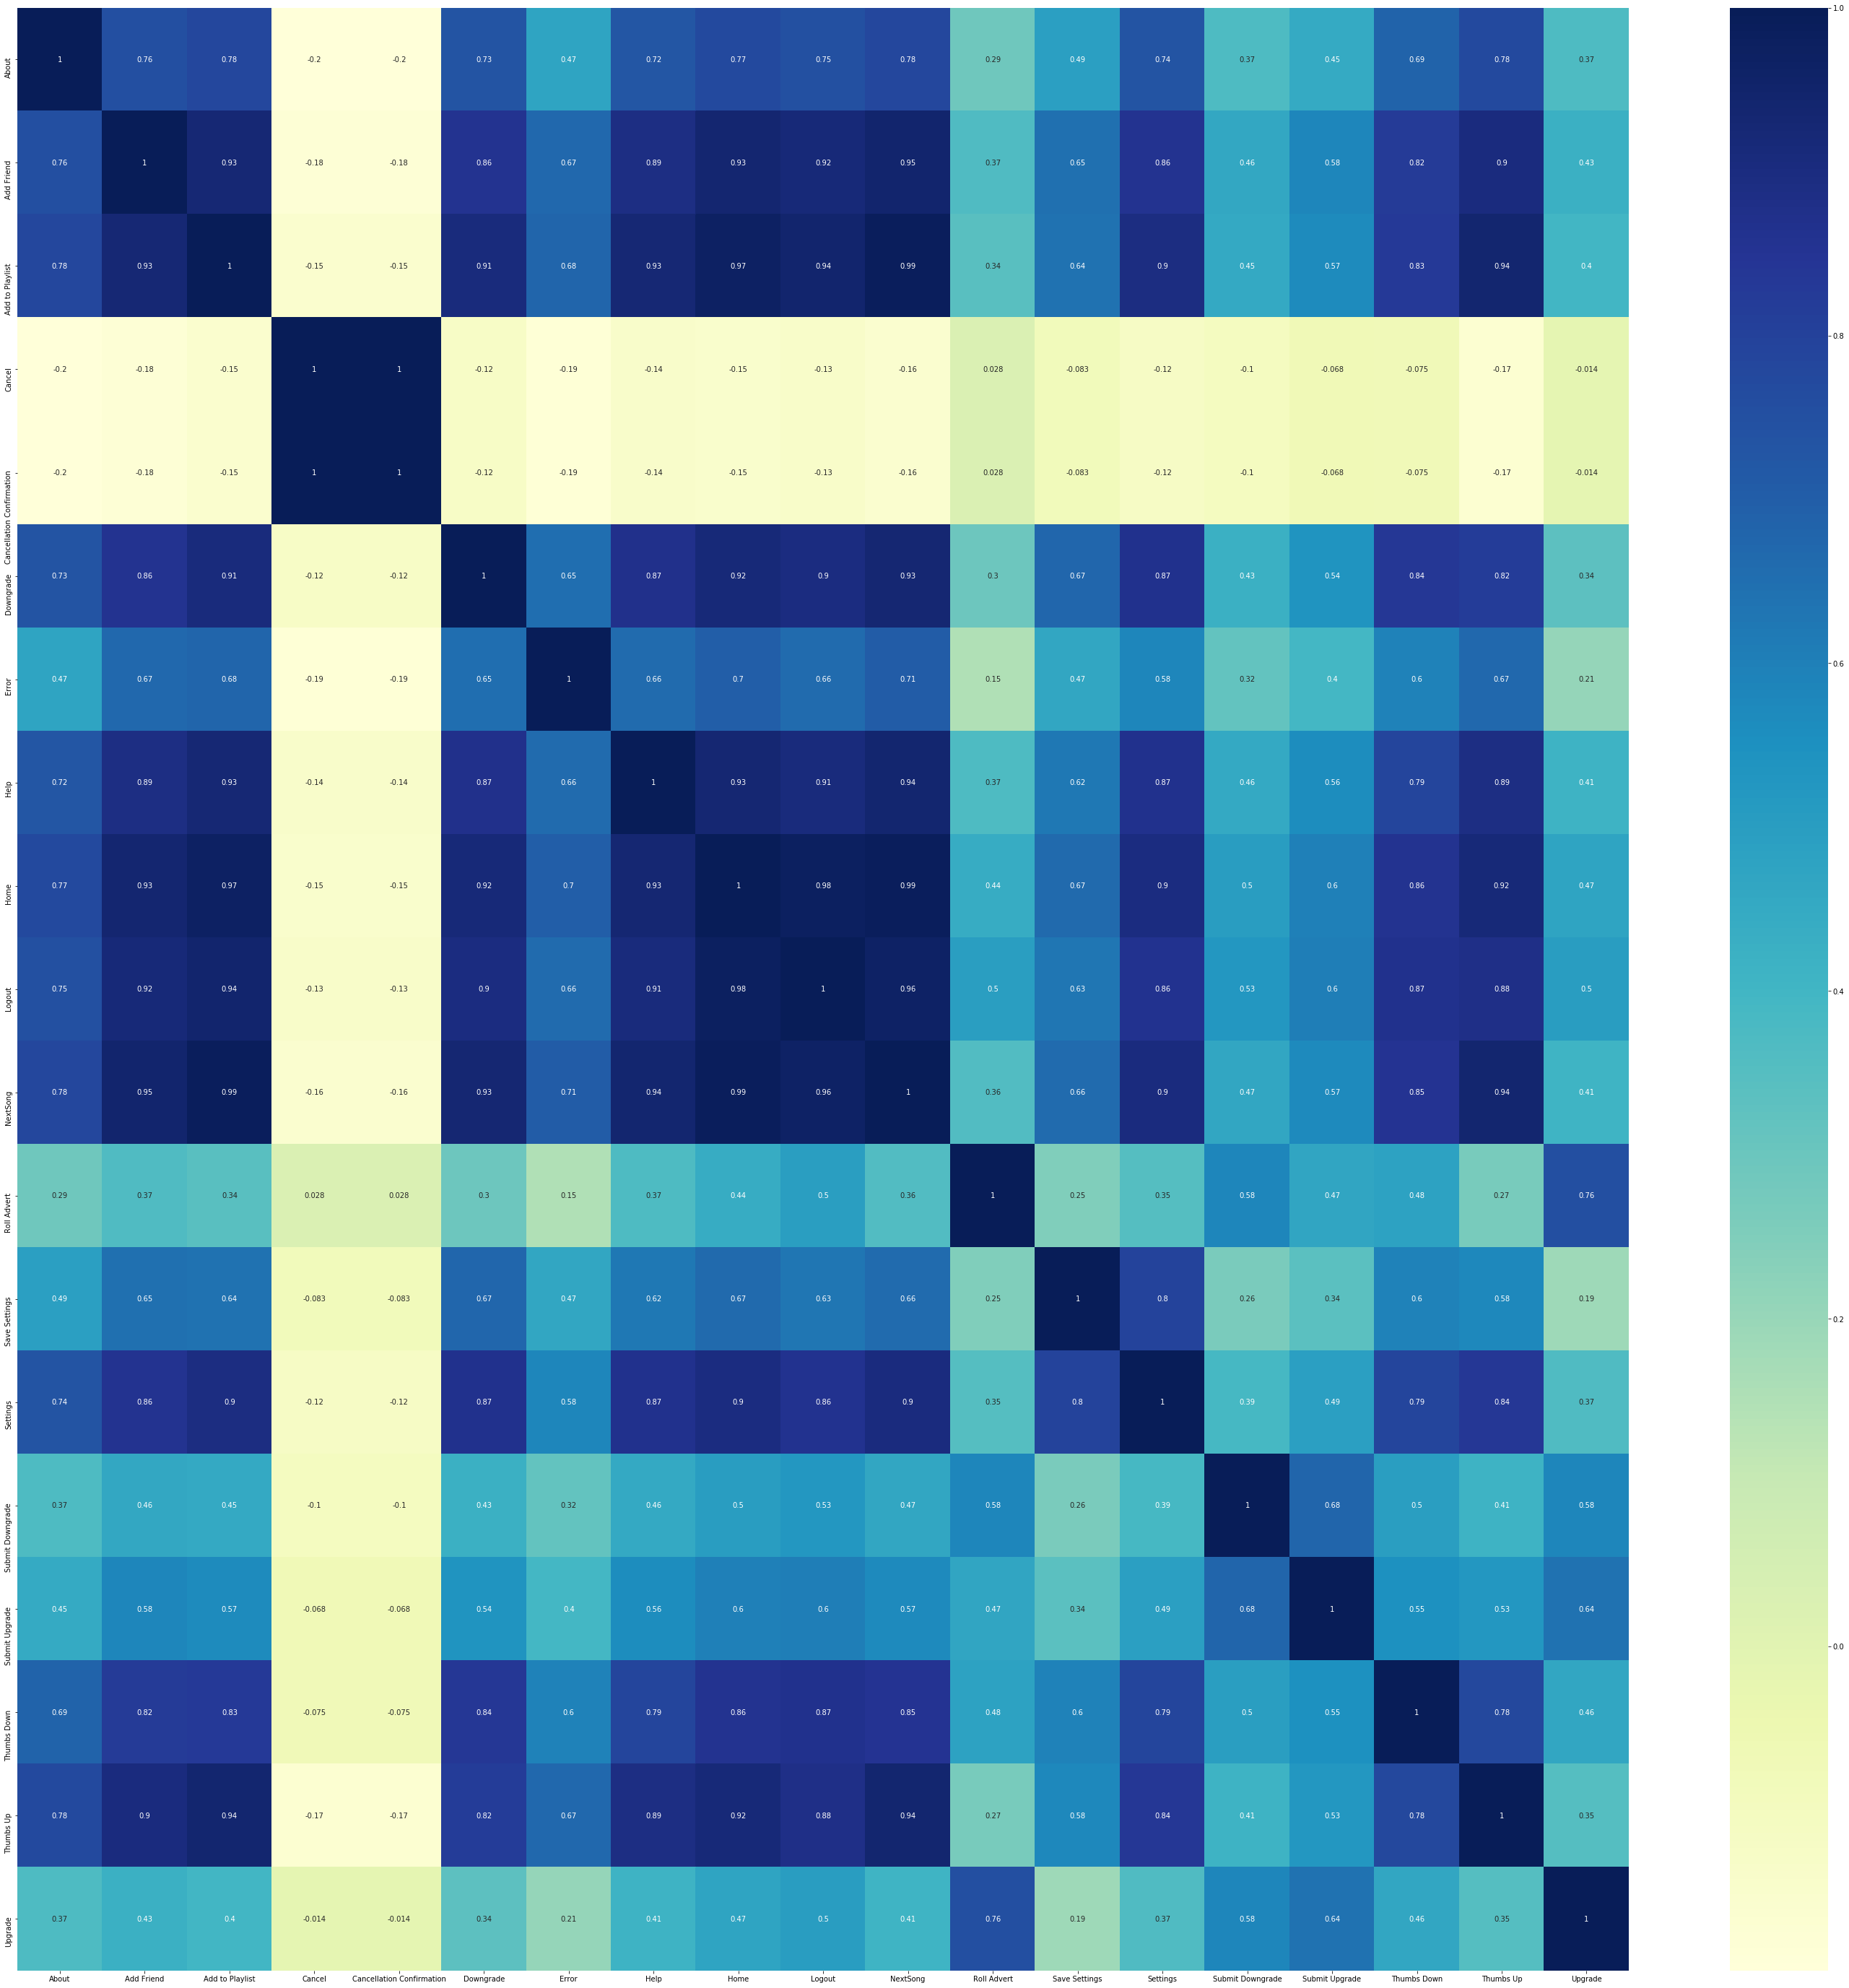

In [44]:
pandas_df = final_df.toPandas()
fig, ax = plt.subplots(figsize=(50,50)) 
sns_plot = sns.heatmap(pandas_df.corr(), annot=True, cmap="YlGnBu", ax=ax)
fig = sns_plot.get_figure()
fig.savefig("heatmap.png") 

'Cancel' and 'Cancellation Confirmation' are highly correlated. So we drop the column 'Cancel', and rename 'Cancellation Confirmation' to 'label'.

In [45]:
final_df = final_df.drop('Cancel').withColumnRenamed('Cancellation Confirmation', 'label')

In [46]:
# Add feature -  total length of all the songs played by each user.
total_songs_length = data.filter(data.page == 'NextSong').groupby('userId').agg(sum('length'))

final_df = final_df.join(total_songs_length, on = 'userId', how = 'left') \
                   .withColumnRenamed('NextSong', 'Total Songs Played') \
                   .withColumnRenamed('sum(length)', 'Total Songs Length')
                   

In [47]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [48]:
# Add feature : Average number of songs played per day by each user
temp = data.select(['userId', 'ts', 'page']).filter(data.page == 'NextSong').withColumn('date', get_date('ts'))
count_by_days = temp.groupby(['userId', 'date']).count()
avg_songs_per_day = count_by_days.groupby('userId').agg(mean('count')).withColumnRenamed('avg(count)', 'Average Songs Per Day')

final_df = final_df.join(avg_songs_per_day, on = 'userId', how = 'left')

In [49]:
# Add feature : Number of days between registration and last log entry
temp = data.select(['userId', 'ts', 'registration'])
registration_timestamp = temp.groupby('userId').min('registration')
min_timestmp = temp.select(['userId', 'ts']).groupby('userId').min('ts')
max_timestmp = temp.select(['userId', 'ts']).groupby('userId').max('ts')

days_registered = registration_timestamp.join(min_timestmp, on='userId').join(max_timestmp, on='userId')
days_registered = days_registered.withColumn('Registration Date', get_date('min(registration)')) \
                         .withColumn('Max Date', get_date('max(ts)')).withColumn('Min Date', get_date('min(ts)')) \
                         .withColumn('Days Registered',  datediff(col('Max Date'), col('Registration Date'))) \
                         .select(['userId', 'Days Registered'])

final_df = final_df.join(days_registered, on = 'userId', how = 'left')

In [50]:
# Add feature : Number of days each user has visited the site.
temp = data.select(['userId', 'ts', 'page']).withColumn('date', get_date('ts'))
count_by_days = temp.groupby(['userId', 'date']).count()
days_visited = count_by_days.groupby('userId').agg(count('date')).withColumnRenamed('count(date)', 'Days Visited')

final_df = final_df.join(days_visited, on = 'userId', how = 'left')

In [51]:
# Add feature : Most recent level of user
flag_paid_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

levels = data.select(['userId', 'ts', 'level']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])
'''temp = data.select(['userId', 'ts', 'level'])
max_ts = temp.groupby(['userId']).max('ts').withColumnRenamed('max(ts)', 'ts')
levels = max_ts.join(temp, on = ['userId', 'ts'], how = 'left').select(['userId', 'level'])'''
levels = levels.withColumn('level', flag_paid_level('level'))

final_df = final_df.join(levels, on = 'userId', how = 'left')

In [52]:
# Add feature : gender
flag_male_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
levels = data.select(['userId', 'gender']).dropDuplicates(['userId']).withColumn('gender', flag_male_gender('gender'))

final_df = final_df.join(levels, on = 'userId', how = 'left')

In [53]:
# Add feature : userAgent

def extract_os_info(input):
    if 'Windows' in input:
        return 'Windows'
    elif 'Linux' in input:
        return 'Linux'
    elif 'Mac OS X' in input:
        return 'Mac OS X'

get_os = udf(extract_os_info, StringType())
temp_df = data.select('userId', 'userAgent').dropDuplicates(['userId']).withColumn('userAgent', get_os('userAgent'))

In [54]:
indexer = StringIndexer(inputCol="userAgent", outputCol="userAgentIndex")
temp_df = indexer.fit(temp_df).transform(temp_df)

encoder = OneHotEncoderEstimator(inputCols=['userAgentIndex'], outputCols=['userAgentVec'])
encoded = encoder.fit(temp_df).transform(temp_df).select(['userId', 'userAgentVec'])

final_df = final_df.join(encoded, on = 'userId', how = 'left')

In [55]:
final_df.show()

+------+-----+----------+---------------+-----+---------+-----+----+----+------+------------------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+------------------+---------------------+---------------+------------+-----+------+-------------+
|userId|About|Add Friend|Add to Playlist|label|Downgrade|Error|Help|Home|Logout|Total Songs Played|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|Total Songs Length|Average Songs Per Day|Days Registered|Days Visited|level|gender| userAgentVec|
+------+-----+----------+---------------+-----+---------+-----+----+----+------+------------------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+------------------+---------------------+---------------+------------+-----+------+-------------+
|100010|    1|         4|              7|    0|        0|    0|   2|  11|     5|               275|         52|       

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
feature_names = final_df.drop('userId', 'label').schema.names
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
df = assembler.transform(final_df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(df)
scaled_df = scalerModel.transform(df)

training_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [39]:
def evaluate_prediction(predictions):
    '''Evaluates the input predictions. Prints accuracy and f1 score, and returns the confusion matrix.'''
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy: ", accuracy)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    print("F1 Score: ", f1_score)

    confusion_matrix = predictions.groupby("label").pivot("prediction").count().toPandas()
    return confusion_matrix

#### Random Forest Classifier:

In [40]:
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=50)
rf_model = rf.fit(training_df)
rf_predictions = rf_model.transform(test_df)
'''evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
areaUnderROC = evaluator.evaluate(rf_predictions)
print("areaUnderROC: ", areaUnderROC)'''
evaluate_prediction(rf_predictions)

Accuracy:  0.8823529411764706
F1 Score:  0.8669467787114846


,label,0.0,1.0
0,0,26,NaN
1,1,4,4.0


#### Logistic Regression:

In [41]:
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=50, regParam=0.01)
lr_model = lr.fit(training_df)
lr_predictions = lr_model.transform(test_df)
evaluate_prediction(lr_predictions)

Accuracy:  0.8235294117647058
F1 Score:  0.7797160243407708


,label,0.0,1.0
0,0,26,NaN
1,1,6,2.0


#### Gradient-Boosted Tree Classifier:

In [42]:
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="label", maxIter=50)
gbt_model = gbt.fit(training_df)
gbt_predictions = gbt_model.transform(test_df)
evaluate_prediction(gbt_predictions)

Accuracy:  0.7647058823529411
F1 Score:  0.7647058823529412


,label,0.0,1.0
0,0,22,4
1,1,4,4


Random Forest gives the highest F1 score. Let's continue with Random Forest.

#### Creating Pipeline with Random Forest:

In [40]:
training_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)
#validation_df, test_df = rest.randomSplit([0.5,0.5], seed=42)

feature_names = final_df.drop('userId', 'label').schema.names

assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=10)

pipeline = Pipeline(stages=[assembler, scaler, rf])
model = pipeline.fit(training_df)
preds = model.transform(test_df)
evaluate_prediction(preds)

Accuracy:  0.7647058823529411
F1 Score:  0.706288032454361


,label,0.0,1.0
0,0,25,1
1,1,7,1


#### Model Tuning:

In [41]:
# TODO: write your code for this step
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).addGrid(rf.maxDepth,[2, 4, 10]).build()

crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, 
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
cv_model = crossval.fit(training_df)
predictions = cv_model.transform(test_df)
evaluate_prediction(predictions)

Accuracy:  0.8529411764705882
F1 Score:  0.8259686649779528


,label,0.0,1.0
0,0,26,NaN
1,1,5,3.0


In [42]:
best_model = cv_model.bestModel
best_model

PipelineModel_06896808b7d9

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.